# Couple a simple single column model to the RRTMG scheme and explore ECS

The thermal structure of the atmosphere is assumed to follow the pseudoadiabatic lapse rate in the troposphere, with an overlying isothermal stratosphere at a fixed tropopause temperature, following Seeley and Jeevanjee (2020).

In [291]:
%matplotlib inline 
import climlab
import numpy as np
from matplotlib import pyplot as plt
import scipy.integrate as sp  #Gives access to the ODE integration package
from attrdict import AttrDict

In [295]:
class Dummy:
    pass

params = Dummy()

params.eps   = 0.622 # molar mass ratio of vapour to total moist air
params.L     = 2260000 # Latent heat of vap, water, J/kg

params.R_a   = 287.058 # gas constant for dry air, J/kg/K
params.R_c   = 461.5  # gas constant for water vapour, J/kg/K
params.cp_a  = 1004 # specific heat capacity of air, J/kg/K

params.Tstrat = 200 # isothermal stratosphere, K

params.RH = 0.8 

In [ ]:
import climlab
import numpy as np
import scipy.integrate as sp  

from climlab.utils.thermo import pseudoadiabat

def generate_idealized_temp_profile(SST, Tstrat, plevs):
    solution = sp.odeint(pseudoadiabat, SST, np.flip(plevs))
    temp = solution.reshape(-1)
    temp[np.where(temp<Tstrat)] = Tstrat
    return np.flip(temp) # need to re-invert the pressure axis

Tstrat = 200 # isothermal stratosphere, K
SST = 288.
CO2ppmv = 280.
RH = 0.8

state = climlab.column_state(num_lev=30, num_lat=1, water_depth=1.)
plevs = state['Tatm'].domain.axes['lev'].points
state['Ts'][:] = SST
state['Tatm'][:] = generate_idealized_temp_profile(SST, Tstrat, plevs)
h2o = climlab.radiation.water_vapor.FixedRelativeHumidity(state=state,
                                                          relative_humidity=RH)
rad = climlab.radiation.RRTMG(state=state, specific_humidity=h2o.q, albedo=0.3, ozone_file=None,
                              absorber_vmr = {'CO2':CO2ppmv/1e6,
                                              'CH4':0.,
                                              'N2O':0.,
                                              'O2':0.,
                                              'CFC11':0.,
                                              'CFC12':0.,
                                              'CFC22':0.,
                                              'CCL4':0.,
                                              'O3':0.})
rad.compute_diagnostics()

In [303]:
# Define functions

def q(T, P): # specific humidity at saturation (using Clausius-Clapeyron)
    return climlab.utils.thermo.qsat(T, P)

def moist_adiabat(T, P): # Pressure coords gives dT/dP (if using the T/P prefactor)
    return np.divide(T, P) * np.divide(params.R_a, params.cp_a) * np.divide(1 + np.divide(params.L*q(T, P), params.R_a * T), 
                                                                            1 + np.divide(params.L**2 * q(T, P), params.cp_a * params.R_c * T**2))

# Or, equivalently...
def pseudoadiabat(T,p):
    return climlab.utils.thermo.pseudoadiabat(T, p)

def dry_adiabat(T):
    return np.divide(params.params.R_a, cp_a)

def generate_idealized_temp_profile(SST, Tstrat, plevs):
    solution = sp.odeint(pseudoadiabat, SST, np.flip(plevs))
    temp = solution.reshape(-1)
    temp[np.where(temp<Tstrat)] = Tstrat
    return np.flip(temp) # need to re-invert the pressure axis

In [304]:
def calc_olr(SST, CO2ppmv):
    ## RRTMG
    #  Couple water vapor to radiation
    ## climlab setup
    # create surface and atmosperic domains
    state = climlab.column_state(num_lev=30, num_lat=1, water_depth=1.)
    plevs = state['Tatm'].domain.axes['lev'].points
    state['Ts'][:] = SST
    state['Tatm'][:] = generate_idealized_temp_profile(SST, params.Tstrat, plevs)

    #  fixed relative humidity
    h2o = climlab.radiation.water_vapor.FixedRelativeHumidity(state=state,
                                                              relative_humidity=params.RH)

    # RRTMG radiation
    rad = climlab.radiation.RRTMG(state=state, specific_humidity=h2o.q, 
                                  albedo=0.3, ozone_file=None,
                                  absorber_vmr = {'CO2':CO2ppmv/1e6,
                                                  'CH4':0.,
                                                  'N2O':0.,
                                                  'O2':0.,
                                                  'CFC11':0.,
                                                  'CFC12':0.,
                                                  'CFC22':0.,
                                                  'CCL4':0.,
                                                  'O3':0.})
    rad.compute_diagnostics()
    olr = rad.OLR
    return olr

In [305]:
OLR0 = calc_olr(SST=288,CO2ppmv=280)
OLR0

Field([256.53037766])

In [306]:
OLRS = np.zeros((10,10))

for idx1, temp in enumerate(np.linspace(280, 290, 10)):
    for idx2, co2 in enumerate(np.linspace(280, 1200, 10)):
        OLRS[idx1, idx2] = calc_olr(temp, co2)

In [312]:
import xarray as xr
da=xr.DataArray(OLRS, dims=['temp', 'co2'], coords={'temp':np.linspace(280, 290, 10), 'co2':np.linspace(280, 1200, 10)})
da

<xarray.DataArray (temp: 10, co2: 10)>
array([[240.75077886, 239.11670346, 237.83056209, 236.76071829,
        235.83974089, 235.02508901, 234.29460532, 233.62962363,
        233.0141918 , 232.46513658],
       [243.03710419, 241.37582737, 240.07903869, 238.99788445,
        238.06912158, 237.24823906, 236.51105435, 235.84077093,
        235.21910645, 234.66523527],
       [245.30542396, 243.61877317, 242.30930008, 241.22035812,
        240.28141329, 239.45451858, 238.71123752, 238.03454033,
        237.40908634, 236.84995525],
       [247.54485856, 245.84018825, 244.51867282, 243.41911143,
        242.47417485, 241.63856397, 240.8902154 , 240.20759061,
        239.57655692, 239.01511422],
       [249.7620701 , 248.0363709 , 246.70527958, 245.59492211,
        244.64052688, 243.80057315, 243.04441599, 242.35811373,
        241.72246645, 241.15707717],
       [251.93509837, 250.19957987, 248.85016338, 247.7345682 ,
        246.77153589, 245.9227173 , 245.163282  , 244.4714914 ,
        243.82853909, 243.25968864],
       [254.04819355, 252.30897556, 250.94228638, 249.81770139,
        248.85147187, 247.9947359 , 247.22639728, 246.53038377,
        245.88545445, 245.3111953 ],
       [256.12340964, 254.37060133, 252.99480422, 251.86524241,
        250.88703029, 250.02737523, 249.25396202, 248.55310605,
        247.90112641, 247.32342858],
       [258.14854103, 256.39432442, 255.00600305, 253.86776327,
        252.8890944 , 252.01999446, 251.24325961, 250.53413001,
        249.88118486, 249.30074491],
       [260.13095944, 258.37032342, 256.9822386 , 255.82723369,
        254.84148474, 253.97350843, 253.19231426, 252.47967751,
        251.82037794, 251.23603619]])
Coordinates:
  * temp     (temp) float64 280.0 281.1 282.2 283.3 ... 286.7 287.8 288.9 290.0
  * co2      (co2) float64 280.0 382.2 484.4 586.7 ... 995.6 1.098e+03 1.2e+03

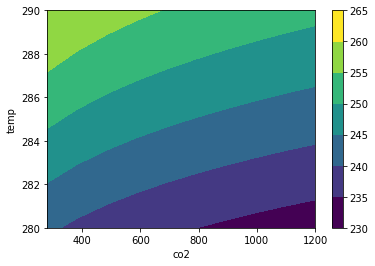

In [317]:
da.plot.contourf()

In [338]:
%%time

TEMPS = np.linspace(280, 320, 41)
CO2_arr = np.zeros(len(TEMPS))

OLR0 = calc_olr(SST=288,CO2ppmv=280)

co2_init = 0
for idx,sst in enumerate(TEMPS):
    print(sst)
    
    if idx==0:
        co2_trial=co2_init
    
    olr = calc_olr(SST=sst,CO2ppmv=co2_trial)
    
    while abs(olr-OLR0)>1:
        if olr-OLR0>0:
            co2_trial+=1
            olr = calc_olr(SST=sst,CO2ppmv=co2_trial)
        if olr-OLR0<0:
            co2_trial-=1
            olr = calc_olr(SST=sst,CO2ppmv=co2_trial)
        #print(co2_trial, olr, OLR0)
    CO2_arr[idx] = co2_trial

280.0
281.0
282.0
283.0
284.0
285.0
286.0
287.0
288.0
289.0
290.0
291.0
292.0
293.0
294.0
295.0
296.0
297.0
298.0
299.0
300.0
301.0
302.0
303.0
304.0
305.0
306.0
307.0
308.0
309.0
310.0
311.0
312.0
313.0
314.0
315.0
316.0
317.0
318.0
319.0
320.0
CPU times: user 9min 14s, sys: 4.2 s, total: 9min 19s
Wall time: 9min 30s


Text(0.5, 0, 'T$_{s}$ (K)')

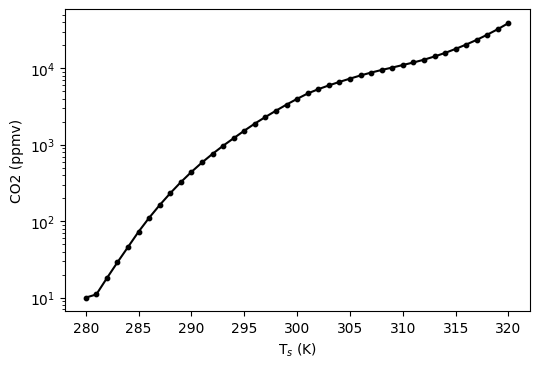

In [346]:
fig, ax = plt.subplots(dpi=100)

ax.plot(TEMPS, CO2_arr, 'k')
ax.scatter(TEMPS, CO2_arr, color='k', marker='o', s=10)

ax.set_yscale('log')

ax.set_ylabel("CO2 (ppmv)")
ax.set_xlabel(r"T$_{s}$ (K)")